In [1]:
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
# load the dataset
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.preprocessing import StandardScaler , RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier

In [2]:
income = pd.read_csv("./../Data/income_evaluation.csv")

In [3]:
newcol = [i.strip() for i in income.columns.tolist()]
income.columns = newcol

In [4]:
income.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
age               32561 non-null int64
workclass         32561 non-null object
fnlwgt            32561 non-null int64
education         32561 non-null object
education-num     32561 non-null int64
marital-status    32561 non-null object
occupation        32561 non-null object
relationship      32561 non-null object
race              32561 non-null object
sex               32561 non-null object
capital-gain      32561 non-null int64
capital-loss      32561 non-null int64
hours-per-week    32561 non-null int64
native-country    32561 non-null object
income            32561 non-null object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [5]:
# Custom Transformer that extracts columns passed as argument
class FeatureSelector(BaseEstimator, TransformerMixin):
    #Class Constructor 
    def __init__(self, feature_names):
        self.feature_names = feature_names
    #Return self nothing else to do here    
    def fit(self, X, y = None):
        return self
    #Method that describes what we need this transformer to do
    def transform(self, X, y = None):
        return X[self.feature_names]
    
class MissingTransformer( BaseEstimator, TransformerMixin ):
    def __init__(self, MissingImputer):
        self.MissingImputer = MissingImputer
    #Return self nothing else to do here    
    def fit( self, X, y = None ):
        return self
    def transform(self, X , y = None ):
        cols = X.columns.tolist()
        df = X.copy()
        result = self.MissingImputer.fit_transform(df)
        result = pd.DataFrame(result , columns = cols )
        return result
    
# converts certain features to categorical
class NumericalTransformer( BaseEstimator, TransformerMixin ):
    #Class constructor method that takes a boolean as its argument
    def __init__(self, new_features=True):
        self.new_features = new_features
    #Return self nothing else to do here    
    def fit( self, X, y = None ):
        return self
    #Transformer method we wrote for this transformer 
    def transform(self, X , y = None ):
        df = X.copy()
        # convert columns to numerical
        columns =df.columns.to_list()
        for name in columns :
            if name == "age" :
                value = RobustScaler().fit_transform(df[name].values.reshape(-1,1))
            else :
                value = StandardScaler().fit_transform(df[name].values.reshape(-1,1))
            df[name] = value
        # returns numpy array
        return df
    
# converts certain features to categorical
class CategoricalTransformer( BaseEstimator, TransformerMixin ):
    #Class constructor method that takes a boolean as its argument
    def __init__(self, new_features=True):
        self.new_features = new_features
    #Return self nothing else to do here    
    def fit( self, X, y = None ):
        return self
    #Transformer method we wrote for this transformer 
    def transform(self, X , y = None ):
        df = X.copy()
        if self.new_features:
            # Treat ? workclass as unknown
            df['workclass']= df['workclass'].replace('?','Unknown') 
            # Two many category level, convert just US and Non-US
            df.loc[df['native-country']!=' United-States','native-country'] = 'non_usa'
            df.loc[df['native-country']==' United-States','native-country'] = 'usa'
        # convert columns to categorical
        columns =df.columns.to_list()
        for name in columns :
            col = pd.Categorical(df[name])
            df[name] = col.codes
        # returns numpy array
        return df

In [6]:
y = income.pop("income")
X = income

In [7]:
col = pd.Categorical(y)
y = pd.Series(col.codes)
# global variables
seed = 108

In [8]:
X.loc[[0,1,2]] = np.nan

In [9]:
# get the categorical feature names
categorical_features = X.select_dtypes("object").columns.to_list()
# get the numerical feature names
numerical_features = X.select_dtypes("float").columns.to_list()
# create the steps for the categorical pipeline
categorical_steps = [
    ('cat_selector', FeatureSelector(categorical_features)),
    ('imputer', MissingTransformer(SimpleImputer(strategy='constant', 
                                                 missing_values=np.nan,
                                                 fill_value='missing'))),
    ('cat_transformer', CategoricalTransformer())
]
# create the steps for the numerical pipeline
numerical_steps = [
    ('num_selector', FeatureSelector(numerical_features)),
    ('imputer', MissingTransformer(SimpleImputer(strategy='median'))),
    ('std_scaler', NumericalTransformer()),
]
# create the 2 pipelines with the respective steps
categorical_pipeline = Pipeline(categorical_steps)
numerical_pipeline = Pipeline(numerical_steps)

In [10]:
len(categorical_features) , len(numerical_features)

(8, 6)

In [11]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 14 columns):
age               32558 non-null float64
workclass         32558 non-null object
fnlwgt            32558 non-null float64
education         32558 non-null object
education-num     32558 non-null float64
marital-status    32558 non-null object
occupation        32558 non-null object
relationship      32558 non-null object
race              32558 non-null object
sex               32558 non-null object
capital-gain      32558 non-null float64
capital-loss      32558 non-null float64
hours-per-week    32558 non-null float64
native-country    32558 non-null object
dtypes: float64(6), object(8)
memory usage: 3.5+ MB


In [12]:
pipeline_list = [
    ('categorical_pipeline', categorical_pipeline),
    ('numerical_pipeline', numerical_pipeline)
]
# Combining the 2 pieplines horizontally into one full pipeline 
preprocessing_pipeline =FeatureUnion(transformer_list=pipeline_list)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,
                                                    random_state=seed, shuffle=True, stratify=y)

In [14]:
full_pipeline_steps = [
    ('preprocessing_pipeline', preprocessing_pipeline),
    ('model', DecisionTreeClassifier(random_state=seed))
]
# create the full pipeline object
full_pipeline = Pipeline(steps=full_pipeline_steps)

In [18]:
param_grid = {
    "model": [DecisionTreeClassifier(random_state=seed)],
    "model__criterion": ["gini","entropy"],
    "model__splitter": ["best","random"],
    "model__max_leaf_nodes": [16, 64, 128, 256],
    "model__max_depth": np.linspace(1, 32, 32)
}
scoring = {
    'AUC': 'roc_auc', 
    'Accuracy': make_scorer(accuracy_score)
}
# create the Kfold object
num_folds = 10
kfold = StratifiedKFold(n_splits=num_folds, random_state=seed)
# create the grid search object with the full pipeline as estimator
n_iter= 10
grid = RandomizedSearchCV(
    estimator=full_pipeline, 
    param_distributions=param_grid,
    cv=kfold,
    scoring=scoring,
    n_jobs= 1,
    n_iter=n_iter,
    refit="AUC"
)
# fit grid search
best_model = grid.fit(X_train,y_train)

In [19]:
print("Finish")

Finish


In [20]:
pd.DataFrame(best_model.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__splitter,param_model__max_leaf_nodes,param_model__max_depth,param_model__criterion,param_model,params,...,split3_test_Accuracy,split4_test_Accuracy,split5_test_Accuracy,split6_test_Accuracy,split7_test_Accuracy,split8_test_Accuracy,split9_test_Accuracy,mean_test_Accuracy,std_test_Accuracy,rank_test_Accuracy
0,0.089211,0.014024,0.060847,0.007634,random,64,2,gini,"DecisionTreeClassifier(class_weight=None, crit...","{'model__splitter': 'random', 'model__max_leaf...",...,0.759309,0.767754,0.759217,0.759217,0.759217,0.759217,0.759217,0.760020,0.002580,10
1,0.095859,0.003030,0.056098,0.001077,random,128,15,entropy,"DecisionTreeClassifier(class_weight=None, crit...","{'model__splitter': 'random', 'model__max_leaf...",...,0.838004,0.829942,0.841782,0.841782,0.837174,0.840246,0.839478,0.838798,0.004692,4
2,0.092388,0.002525,0.055543,0.001152,best,256,2,entropy,"DecisionTreeClassifier(class_weight=None, crit...","{'model__splitter': 'best', 'model__max_leaf_n...",...,0.829942,0.826104,0.828341,0.829109,0.818356,0.828725,0.822197,0.824593,0.004134,8
3,0.117638,0.004904,0.057075,0.002385,best,16,7,gini,"DecisionTreeClassifier(class_weight=None, crit...","{'model__splitter': 'best', 'model__max_leaf_n...",...,0.848369,0.851440,0.846390,0.850230,0.839478,0.846006,0.844470,0.846399,0.003184,1
4,0.085801,0.001709,0.055774,0.001471,random,16,25,entropy,"DecisionTreeClassifier(class_weight=None, crit...","{'model__splitter': 'random', 'model__max_leaf...",...,0.831478,0.824184,0.828341,0.834101,0.819124,0.823733,0.822965,0.825514,0.004416,7
5,0.144545,0.004261,0.055940,0.001401,best,256,15,gini,"DecisionTreeClassifier(class_weight=None, crit...","{'model__splitter': 'best', 'model__max_leaf_n...",...,0.852207,0.817658,0.849846,0.842934,0.837942,0.812980,0.828725,0.836110,0.012278,5
6,0.081567,0.002757,0.056330,0.001781,random,256,3,gini,"DecisionTreeClassifier(class_weight=None, crit...","{'model__splitter': 'random', 'model__max_leaf...",...,0.826104,0.820345,0.828341,0.797619,0.817972,0.800691,0.819124,0.811310,0.013040,9
7,0.087443,0.002402,0.057157,0.002013,random,16,19,gini,"DecisionTreeClassifier(class_weight=None, crit...","{'model__splitter': 'random', 'model__max_leaf...",...,0.824568,0.828407,0.830261,0.829493,0.817588,0.827189,0.819124,0.827396,0.006035,6
8,0.105770,0.002199,0.057117,0.001894,best,128,4,gini,"DecisionTreeClassifier(class_weight=None, crit...","{'model__splitter': 'best', 'model__max_leaf_n...",...,0.844146,0.845681,0.839862,0.847158,0.839094,0.841398,0.839094,0.841523,0.003041,3
9,0.125433,0.002189,0.055530,0.001915,best,16,6,entropy,"DecisionTreeClassifier(class_weight=None, crit...","{'model__splitter': 'best', 'model__max_leaf_n...",...,0.844146,0.845681,0.839862,0.848310,0.839094,0.841398,0.839094,0.841715,0.003239,2


In [21]:
pred_test = best_model.predict(X_test)
pred_train = best_model.predict(X_train)
print('Train Accuracy: ', accuracy_score(y_train, pred_train))
print('Test Accuraccy: ', accuracy_score(y_test, pred_test))
print('\nConfusion Matrix:')
print(confusion_matrix(y_test,pred_test))
print('\nClassification Report:')
print(classification_report(y_test,pred_test))

Train Accuracy:  0.8444410319410319
Test Accuraccy:  0.8423153692614771

Confusion Matrix:
[[4676  269]
 [ 758  810]]

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.95      0.90      4945
           1       0.75      0.52      0.61      1568

    accuracy                           0.84      6513
   macro avg       0.81      0.73      0.76      6513
weighted avg       0.83      0.84      0.83      6513



In [22]:
full_pipeline_steps = [
    ('preprocessing_pipeline', preprocessing_pipeline),
    ('model', BaggingClassifier(
        DecisionTreeClassifier(max_features="auto", splitter="random",
                               max_leaf_nodes=128, random_state=seed),
        random_state=seed
    ))
]
# create the full pipeline object
full_pipeline = Pipeline(steps=full_pipeline_steps)
# Create the grid search parameter grid
param_grid = {
    "model": [BaggingClassifier(
        DecisionTreeClassifier(max_features="auto",
                               splitter="random", 
                               max_leaf_nodes=128,
                               random_state=seed),
        n_estimators = 500 , 
        bootstrap = True, 
        n_jobs = -1 , 
        oob_score= True , 
        random_state=seed
    )],
    "model__n_estimators":  np.arange(100, 1000, 100),
    "model__max_samples":[0.8, 1.0], 
    "model__max_features": [0.8, 1.0],
    "model__bootstrap": [True],
    "model__oob_score": [True],
}
scoring = {
    'AUC': 'roc_auc', 
    'Accuracy': make_scorer(accuracy_score)
}
# create the Kfold object
num_folds = 3
kfold = StratifiedKFold(n_splits=num_folds, random_state=seed)
# create the grid search object with the full pipeline as estimator
n_iter=10
grid = RandomizedSearchCV(
    estimator=full_pipeline, 
    param_distributions=param_grid,
    cv=kfold,
    scoring=scoring,
    n_jobs= 1,
    n_iter=n_iter,
    refit="AUC"
)
                                      
# fit grid search
best_bag = grid.fit(X_train,y_train)

In [23]:
print(f'Best score: {best_bag.best_score_}')
print(f'Best model: {best_bag.best_params_}')

Best score: 0.9001379651703095
Best model: {'model__oob_score': True, 'model__n_estimators': 700, 'model__max_samples': 0.8, 'model__max_features': 0.8, 'model__bootstrap': True, 'model': BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None,
                                                        criterion='gini',
                                                        max_depth=None,
                                                        max_features='auto',
                                                        max_leaf_nodes=128,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                   

In [24]:
pred_test = best_bag.predict(X_test)
pred_train = best_bag.predict(X_train)
print('Train Accuracy: ', accuracy_score(y_train, pred_train))
print('Test Accuraccy: ', accuracy_score(y_test, pred_test))
print("Out-of-Bag Accuracy: ", best_bag.best_params_['model'].oob_score_)
print('\nConfusion Matrix:')
print(confusion_matrix(y_test,pred_test))
print('\nClassification Report:')
print(classification_report(y_test,pred_test))

Train Accuracy:  0.8453240171990172
Test Accuraccy:  0.8393981268232765
Out-of-Bag Accuracy:  0.839527027027027

Confusion Matrix:
[[4769  176]
 [ 870  698]]

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.96      0.90      4945
           1       0.80      0.45      0.57      1568

    accuracy                           0.84      6513
   macro avg       0.82      0.70      0.74      6513
weighted avg       0.83      0.84      0.82      6513



In [15]:
# we pass the preprocessing pipeline as a step to the full pipeline
full_pipeline_steps = [
    ('preprocessing_pipeline', preprocessing_pipeline),
    ('model', RandomForestClassifier(random_state=seed))
]
# create the full pipeline object
full_pipeline = Pipeline(steps=full_pipeline_steps)
# Create the grid search parameter grid and scoring funcitons
param_grid = {
    "model": [RandomForestClassifier(random_state=seed)],
    "model__max_depth": np.linspace(1, 32, 32),
    "model__n_estimators": np.arange(100, 1000, 100),
    "model__criterion": ["gini","entropy"],
    "model__max_leaf_nodes": [16, 64, 128, 256],
    "model__oob_score": [True],
}
scoring = {
    'AUC': 'roc_auc', 
    'Accuracy': make_scorer(accuracy_score)
}
# create the Kfold object
num_folds = 3
kfold = StratifiedKFold(n_splits=num_folds, random_state=seed)
# create the grid search object with the full pipeline as estimator
n_iter=3
grid = RandomizedSearchCV(
    estimator=full_pipeline, 
    param_distributions=param_grid,
    cv=kfold,
    scoring=scoring,
    n_jobs=1,
    n_iter=n_iter,
    refit="AUC"
)
# fit grid search
best_rf = grid.fit(X_train,y_train)

In [16]:
print(f'Best score: {best_rf.best_score_}')
print(f'Best model: {best_rf.best_params_}')

Best score: 0.9088126561396552
Best model: {'model__oob_score': True, 'model__n_estimators': 700, 'model__max_leaf_nodes': 128, 'model__max_depth': 20.0, 'model__criterion': 'entropy', 'model': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=20.0, max_features='auto', max_leaf_nodes=128,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=700,
                       n_jobs=None, oob_score=True, random_state=108, verbose=0,
                       warm_start=False)}


In [17]:
pred_test = best_rf.predict(X_test)
pred_train = best_rf.predict(X_train)
print('Train Accuracy: ', accuracy_score(y_train, pred_train))
print('Test Accuraccy: ', accuracy_score(y_test, pred_test))
print("Out-of-Bag Accuracy: ", best_rf.best_params_['model'].oob_score_)
print('\nConfusion Matrix:')
print(confusion_matrix(y_test,pred_test))
print('\nClassification Report:')
print(classification_report(y_test,pred_test))

Train Accuracy:  0.867245085995086
Test Accuraccy:  0.8592046675879011
Out-of-Bag Accuracy:  0.8600276412776413

Confusion Matrix:
[[4691  254]
 [ 663  905]]

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.95      0.91      4945
           1       0.78      0.58      0.66      1568

    accuracy                           0.86      6513
   macro avg       0.83      0.76      0.79      6513
weighted avg       0.85      0.86      0.85      6513



In [18]:
# lets get the random forest model configuration and feature names
rf_model = best_rf.best_params_['model']
features = np.array(X_train.columns)
features
# Transforming the test data.

array(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype=object)

In [19]:
X_train.shape

(26048, 14)

In [20]:
X_test.shape

(6513, 14)

In [21]:
new_X_test = preprocessing_pipeline.fit_transform(X_test)
new_X_test.shape

(6513, 14)

In [22]:
new_X_test = pd.DataFrame(new_X_test, columns=features)

Text(0, 0.5, 'Features')

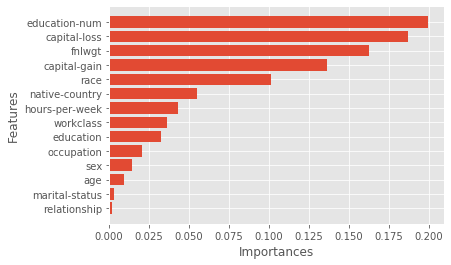

In [23]:

# get the predicitons from the random forest object
y_pred = rf_model.predict(new_X_test)
# get the feature importances
importances = rf_model.feature_importances_
# sort the indexes
sorted_index = np.argsort(importances)
sorted_importances = importances[sorted_index]
sorted_features = features[sorted_index]
# plot the explained variance using a barplot
fig, ax = plt.subplots()
ax.barh(sorted_features , sorted_importances)
ax.set_xlabel('Importances')
ax.set_ylabel('Features')

In [35]:
import eli5
# lets get the random forest model configuration and feature names
rf_model = best_rf.best_params_['model']
features = np.array(X_train.columns)
eli5.show_weights(rf_model, feature_names=features)

Weight,Feature
0.1994 ± 0.2825,education-num
0.1868 ± 0.0886,capital-loss
0.1622 ± 0.2875,fnlwgt
0.1361 ± 0.1083,capital-gain
0.1010 ± 0.1343,race
0.0546 ± 0.0625,native-country
0.0429 ± 0.0371,hours-per-week
0.0362 ± 0.0516,workclass
0.0321 ± 0.0442,education
0.0205 ± 0.0614,occupation


In [46]:
eli5.show_prediction(rf_model , new_X_test.iloc[0])

In [63]:
from eli5.permutation_importance import get_score_importances 
from sklearn.metrics import accuracy_score
def score(X, y):
    y_pred = rf_model.predict(X)
    return accuracy_score(y, y_pred)

base_score , score_decreas = get_score_importances(score , new_X_test.values ,
                                                   y_test , n_iter =10 )

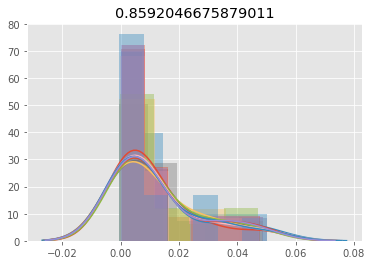

In [74]:
for decreas in score_decreas :
    sns.distplot(decreas)
plt.title(base_score)
plt.show()

In [25]:
# predicting a person earns less than 50k/year (true negative)
index = 4
print('Actual Label:', y_test.iloc[index])
print('Predicted Label:', y_pred[index])
eli5.explain_prediction(rf_model, new_X_test.iloc[index], feature_names=features)
# predicting a person earns more than 50k/year (true positive)
index = 7
print('Actual Label:', y_test.iloc[index])
print('Predicted Label:', y_pred[index])
eli5.explain_prediction(rf_model, new_X_test.iloc[index], feature_names=features)

Actual Label: 0
Predicted Label: 0
Actual Label: 1
Predicted Label: 1


Explanation(estimator="RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',\n                       max_depth=20.0, max_features='auto', max_leaf_nodes=128,\n                       min_impurity_decrease=0.0, min_impurity_split=None,\n                       min_samples_leaf=1, min_samples_split=2,\n                       min_weight_fraction_leaf=0.0, n_estimators=700,\n                       n_jobs=None, oob_score=True, random_state=108, verbose=0,\n                       warm_start=False)", description='\nFeatures with largest coefficients.\n\nFeature weights are calculated by following decision paths in trees\nof an ensemble (or a single tree for DecisionTreeClassifier).\nEach node of the tree has an output score, and contribution of a feature\non the decision path is how much the score changes from parent to child.\nWeights of all features sum to the output score or proba of the estimator.\n\nCaveats:\n1. Feature weights just show if the feature contributed positively or\n   negatively to the final score, and does not show how increasing or\n   decreasing the feature value will change the prediction.\n2. In some cases, feature weight can be close to zero for an important feature.\n   For example, in a single tree that computes XOR function, the feature at the\n   top of the tree will have zero weight because expected scores for both\n   branches are equal, so decision at the top feature does not change the\n   expected score. For an ensemble predicting XOR functions it might not be\n   a problem, but it is not reliable if most trees happen to choose the same\n   feature at the top.\n', error=None, method='decision path', is_regression=False, targets=[TargetExplanation(target=1, feature_weights=FeatureWeights(pos=[FeatureWeight(feature='<BIAS>', weight=0.2410328733766233, std=None, value=1.0), FeatureWeight(feature='education-num', weight=0.10318870268087096, std=None, value=0.0), FeatureWeight(feature='race', weight=0.07016833496715282, std=None, value=0.85), FeatureWeight(feature='fnlwgt', weight=0.06693263692773223, std=None, value=2.0), FeatureWeight(feature='education', weight=0.05821182176526917, std=None, value=12.0), FeatureWeight(feature='workclass', weight=0.030834875661599155, std=None, value=15.0), FeatureWeight(feature='occupation', weight=0.013994240159109807, std=None, value=1.0), FeatureWeight(feature='age', weight=0.005338710772503686, std=None, value=4.0), FeatureWeight(feature='sex', weight=0.001578941958629186, std=None, value=-0.4276014237693241), FeatureWeight(feature='marital-status', weight=0.0015375894457300672, std=None, value=4.0), FeatureWeight(feature='relationship', weight=0.0014591212721286933, std=None, value=1.0)], neg=[FeatureWeight(feature='capital-gain', weight=-0.036299397157995655, std=None, value=-0.0282362153192062), FeatureWeight(feature='capital-loss', weight=-0.03587767875466233, std=None, value=-0.14691019659573076), FeatureWeight(feature='hours-per-week', weight=-0.012568837809618434, std=None, value=-0.21851165166397818), FeatureWeight(feature='native-country', weight=-0.006676912966041082, std=None, value=-0.03456093588261802)], pos_remaining=0, neg_remaining=0), proba=0.5028550222990318, score=None, weighted_spans=None, heatmap=None)], feature_importances=None, decision_tree=None, highlight_spaces=None, transition_features=None, image=None)

In [26]:
import numpy as np
np.__version__

'1.18.0'

In [ ]:
import shap
shap.initjs()

In [27]:
# Create the explainer object
explainer = shap.TreeExplainer(rf_model)
print('Expected Value:', explainer.expected_value)
# get the shap values from the explainer
shap_values = explainer.shap_values(new_X_test)

Expected Value: [0.7589669  0.24103285]


In [90]:
# predicting a person earns less than 50k/year (true negative)
shap.force_plot(explainer.expected_value[0],
                shap_values[0][4], X_test.iloc[4])
# predicting a person earns more than 50k/year (true positive)

In [91]:
# predicting a person earns less than 50k/year (true negative)
shap.force_plot(explainer.expected_value[1],
                shap_values[1][4], X_test.iloc[4])
# predicting a person earns more than 50k/year (true positive)

In [92]:
shap.force_plot(explainer.expected_value[1],
                shap_values[1][7], X_test.iloc[7])

In [93]:
shap.force_plot(explainer.expected_value[0],
                shap_values[0][:1000,:], X_test.iloc[:1000,:])

In [94]:
shap.force_plot(explainer.expected_value[1],
                shap_values[1][:1000,:], X_test.iloc[:1000,:])

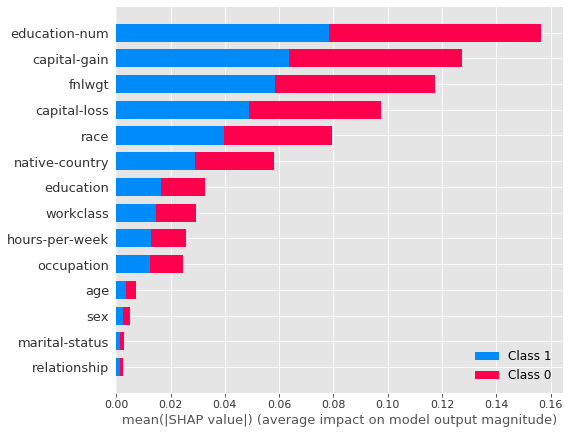

In [95]:
shap.summary_plot(shap_values, X_test)

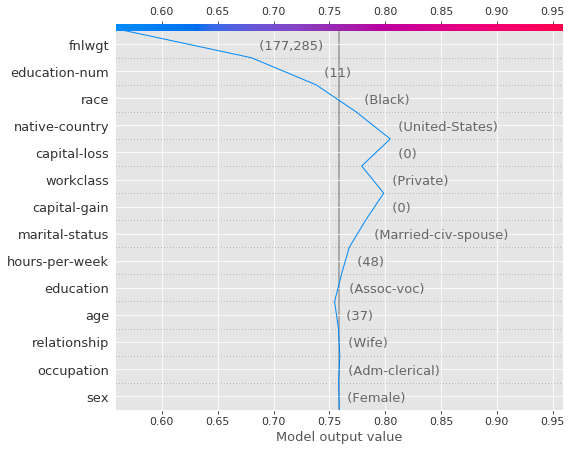

In [104]:
c = 0 
i = 2
shap.decision_plot(explainer.expected_value[c], 
                   shap_values[c][i],
                   X_test.iloc[i], )

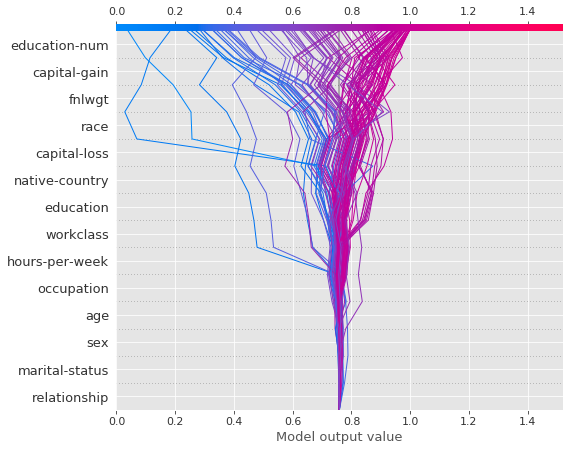

In [103]:
c = 0 
i = 100
shap.decision_plot(explainer.expected_value[c], 
                   shap_values[c][:i],
                   X_test.iloc[:i], )

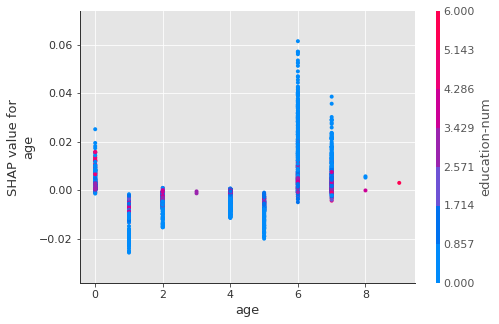

In [117]:
shap.dependence_plot(0 , shap_values[0] , new_X_test)

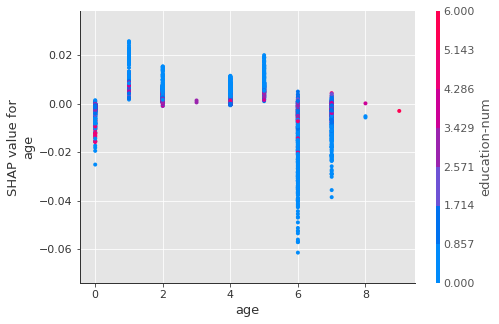

In [116]:
shap.dependence_plot(0 , shap_values[1] , new_X_test)

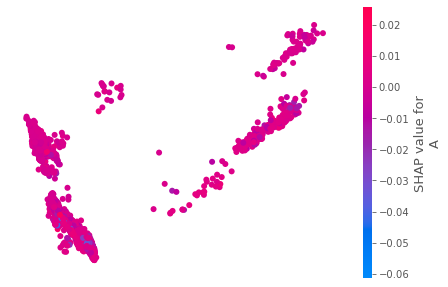

In [120]:
shap.embedding_plot(0 , shap_values[1], feature_names= "AGE")

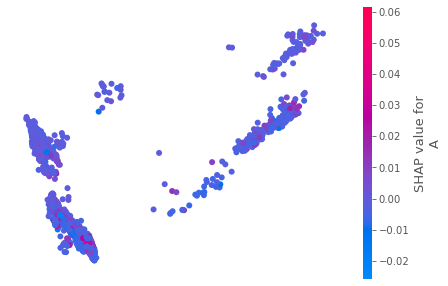

In [121]:
shap.embedding_plot(0 , shap_values[0], feature_names= "AGE")

In [122]:
dir(shap)

['DeepExplainer',
 'GradientExplainer',
 'KernelExplainer',
 'LinearExplainer',
 'PartitionExplainer',
 'SamplingExplainer',
 'Tree',
 'TreeExplainer',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '__version__',
 '_cext',
 'approximate_interactions',
 'benchmark',
 'common',
 'datasets',
 'decision_plot',
 'dependence_plot',
 'embedding_plot',
 'explainers',
 'force_plot',
 'hclust_ordering',
 'image_plot',
 'initjs',
 'kmeans',
 'monitoring_plot',
 'multioutput_decision_plot',
 'other',
 'plots',
 'save_html',
 'summary_plot']

In [129]:
shap.multioutput_decision_plot(y_test.values.tolist(), 
                               shap_values[0] ,
                               row_index = 3)

ValueError: The base_values and shap_values args expect lists.

[0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
